In [1]:
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
from tqdm import tqdm
from PIL import Image

In [2]:
x_data = np.load('Ch07_x_lateral.npy')
y_data = np.load('Ch07_y_lateral.npy')

In [3]:
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.2, stratify = y_data)
x_test, x_valid, y_test, y_valid = train_test_split(x_temp, y_temp, test_size =0.5, stratify = y_temp)
del x_data
del y_data
del x_temp
del y_temp

In [4]:
x_train.shape[0], np.count_nonzero(y_train)/y_train.shape[0], np.count_nonzero(y_test)/y_test.shape[0]

(5082, 0.5387642660369933, 0.5385826771653544)

In [5]:
1 - (np.count_nonzero(y_train) / y_train.shape[0])

0.46123573396300666

In [6]:
model = tf.keras.Sequential()

model.add(tf.keras.applications.EfficientNetB0(include_top=False,
                                             weights='imagenet',
                                             input_shape=(224,224,3),
                                             pooling='max',
                                             classes=2,
                                             classifier_activation='softmax'))

model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 4,052,133
Trainable params: 4,010,110
Non-trainable params: 42,023
_________________________________________________________________


In [7]:
saved_model = 'Ch07_lateral_EfficientNet_B0_test1.h5'
# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50,restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint(saved_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])


In [9]:
history = model.fit(x_train, y_train,
          epochs=100,
          validation_data=(x_test, y_test),
          shuffle=True,
        #   steps_per_epoch=len(train_generator),
        #   validation_steps=len(test_generator),
          callbacks=[early_stopping, learning_rate_reduction, mc],
          batch_size = 16
          )


Epoch 1/100
318/318 [==============================] - 71s 186ms/step - loss: 0.4370 - accuracy: 0.9107 - val_loss: 4.6801 - val_accuracy: 0.9323

Epoch 00001: val_accuracy improved from -inf to 0.93228, saving model to Ch07_lateral_EfficientNet_B0_test1.h5


c:\Users\Chaddol\anaconda3\envs\chaddol\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
318/318 [==============================] - 56s 175ms/step - loss: 0.2648 - accuracy: 0.9335 - val_loss: 148.1942 - val_accuracy: 0.6378

Epoch 00002: val_accuracy did not improve from 0.93228
Epoch 3/100
318/318 [==============================] - 57s 178ms/step - loss: 0.2392 - accuracy: 0.9463 - val_loss: 0.3323 - val_accuracy: 0.9213

Epoch 00003: val_accuracy did not improve from 0.93228
Epoch 4/100
318/318 [==============================] - 63s 197ms/step - loss: 0.1924 - accuracy: 0.9463 - val_loss: 0.1618 - val_accuracy: 0.9260

Epoch 00004: val_accuracy did not improve from 0.93228
Epoch 5/100
318/318 [==============================] - 65s 205ms/step - loss: 0.1230 - accuracy: 0.9561 - val_loss: 0.2069 - val_accuracy: 0.9480

Epoch 00005: val_accuracy improved from 0.93228 to 0.94803, saving model to Ch07_lateral_EfficientNet_B0_test1.h5
Epoch 6/100
318/318 [==============================] - 67s 210ms/step - loss: 0.1263 - accuracy: 0.9624 - val_loss: 0.1793 - val_ac

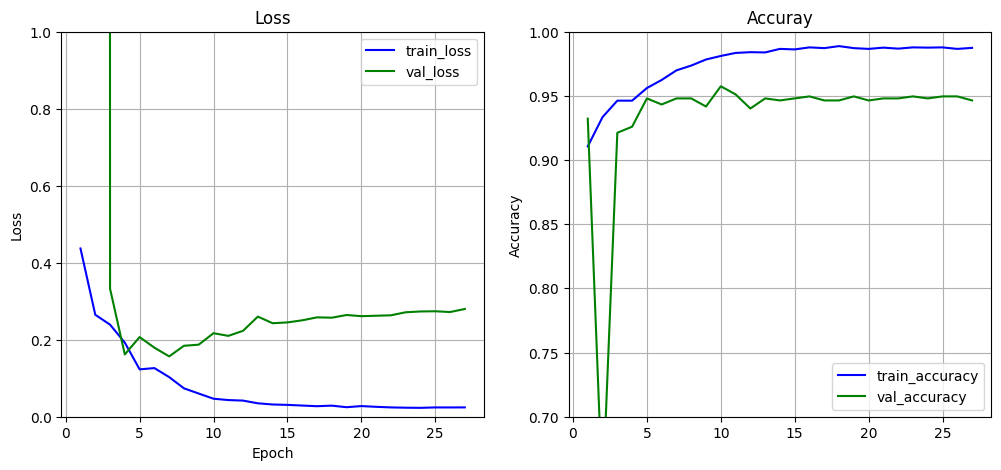

In [10]:
import matplotlib.pyplot as plt

loss = history.history['loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(epochs, history.history['loss'], 'b', label='train_loss')
plt.plot(epochs, history.history['val_loss'], 'g', label='val_loss')
plt.ylim([0,1.0])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuray')
plt.plot(epochs, history.history['accuracy'], 'b', label='train_accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'g', label='val_accuracy')
plt.ylim([0.7,1])
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [11]:
# x_valid = np.load('/content/drive/MyDrive/팀 프로젝트/흉부_xray/128/Ch06_x_valid.npy')
# y_valid = np.load('/content/drive/MyDrive/팀 프로젝트/흉부_xray/128/Ch06_y_valid.npy')

In [12]:
model.evaluate(x_valid, y_valid)

20/20 [==============================] - 4s 131ms/step - loss: 0.1694 - accuracy: 0.9575


[0.1693630963563919, 0.9575471878051758]

In [13]:
y_1 = []
y_0 = []
x_0 = []
x_1 = []
for idx, i in enumerate(y_valid):
  if i == 1:
    y_1.append(i)
    x_1.append(x_valid[idx])
  else:
    y_0.append(i)
    x_0.append(x_valid[idx])


In [14]:
model.evaluate(np.array(x_0),np.array(y_0))

10/10 [==============================] - 2s 172ms/step - loss: 0.2763 - accuracy: 0.9317


[0.2763144373893738, 0.9317406415939331]

In [15]:
model.evaluate(np.array(x_1),np.array(y_1))


11/11 [==============================] - 2s 177ms/step - loss: 0.0780 - accuracy: 0.9796


[0.07800231873989105, 0.9795918464660645]

In [16]:
y_out = np.argmax(model.predict(x_valid),axis=-1)


In [17]:
y_out

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,

In [18]:
x_0, y_0 = np.array(x_0),np.array(y_0)
x_1, y_1 = np.array(x_1),np.array(y_1)

<function matplotlib.pyplot.show(close=None, block=None)>

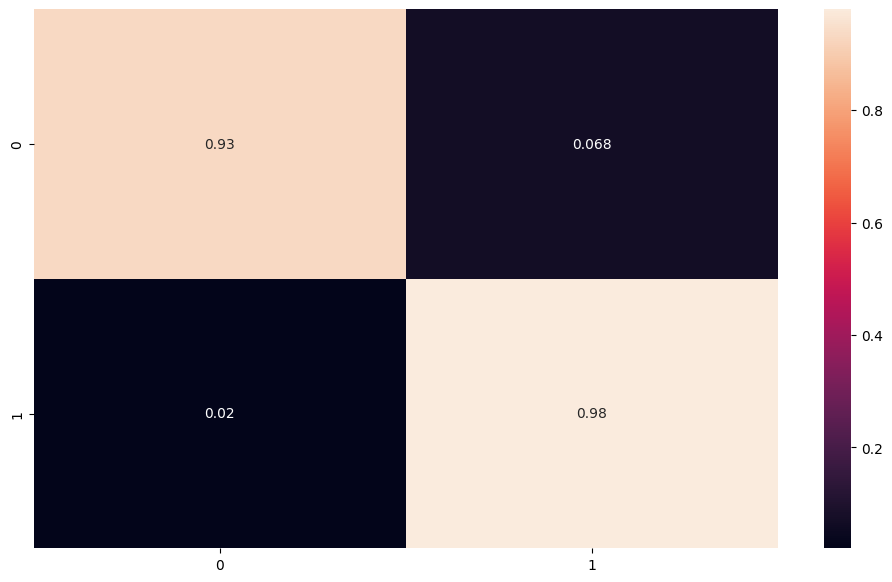

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# x_0은 label == 0인 데이터, x_1은 label == 1인 데이터만 모은 것
cf_matrix = confusion_matrix(y_valid, y_out) / np.array([x_0.shape[0], x_1.shape[0]]).reshape(-1,1)

plt.figure(figsize = (12,7))
sns.heatmap(cf_matrix, annot=True)
plt.show